In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Load results

In [2]:
results = pd.read_hdf('results_fixed_mmseq2.h5')
results.head()

,Representation,Repeat,Label,k,Metric,Value
0,Deep Embeddings,0,EC number,1,IoU,0.932381
1,Deep Embeddings,0,EC number,1,Precision,0.933015
2,Deep Embeddings,0,EC number,1,Recall,0.932950
3,Deep Embeddings,0,EC number,3,IoU,0.903628
4,Deep Embeddings,0,EC number,3,Precision,0.903950


In [3]:
results = results.query('Representation != "3-mers"')

In [4]:
results['Representation'] = results['Representation'].astype('category')
results['Label'] = results['Label'].astype('category')
results['Metric'] = results['Metric'].astype('category')

In [5]:
results['Representation']

0      Deep Embeddings
1      Deep Embeddings
2      Deep Embeddings
3      Deep Embeddings
4      Deep Embeddings
            ...       
355            mmseqs2
356            mmseqs2
357            mmseqs2
358            mmseqs2
359            mmseqs2
Name: Representation, Length: 1152, dtype: category
Categories (4, object): ['3-mers TF-IDF', 'AA freq.', 'Deep Embeddings', 'mmseqs2']

In [6]:
palette={
    '3-mers TF-IDF': "#2fc7bd",
    'AA freq.': "#d3759e",
    'Deep Embeddings': "#734BC2",
    'mmseqs2': "#22967b"
}

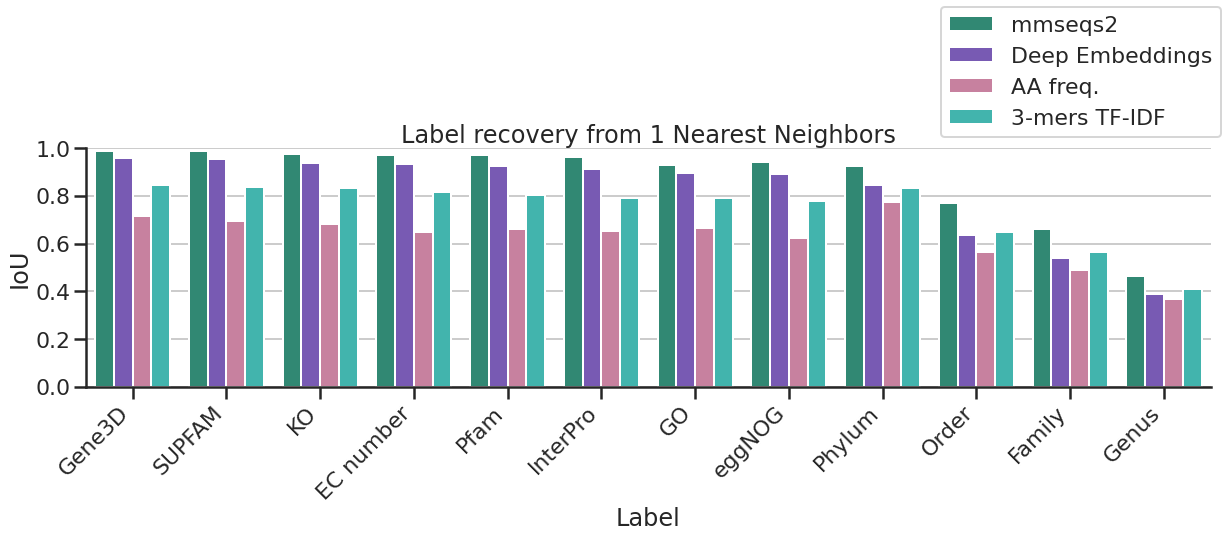

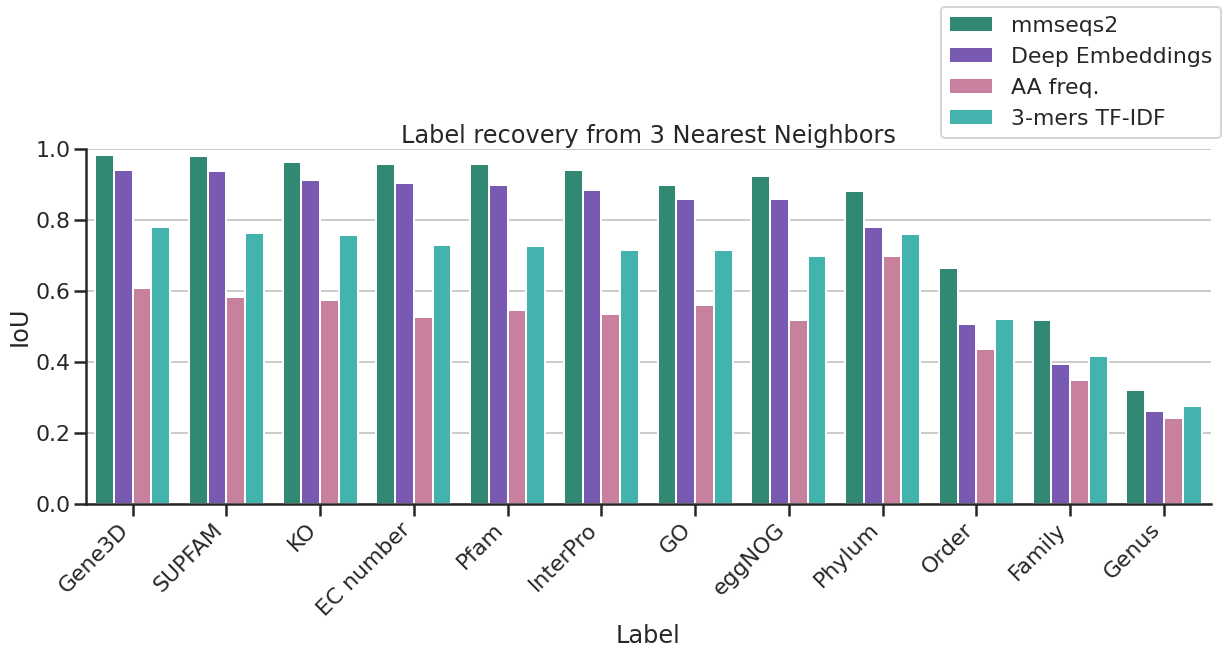

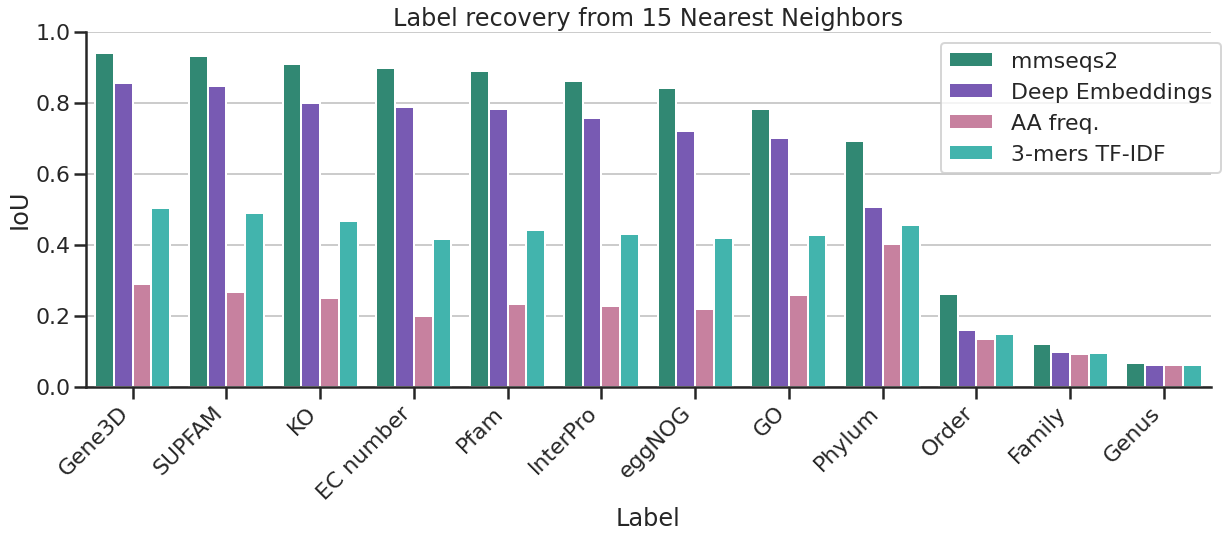

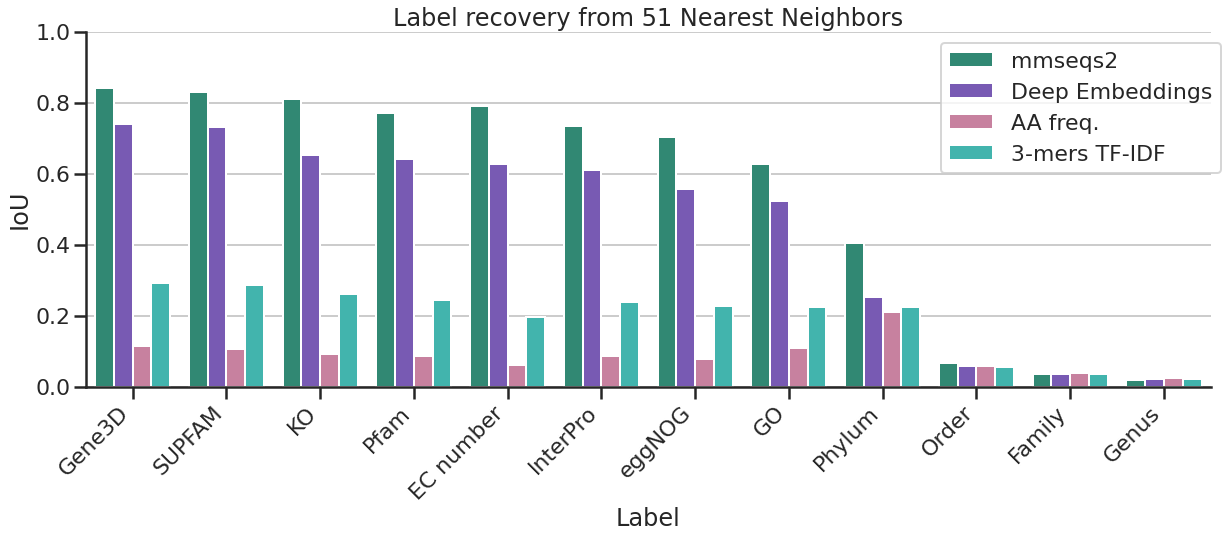

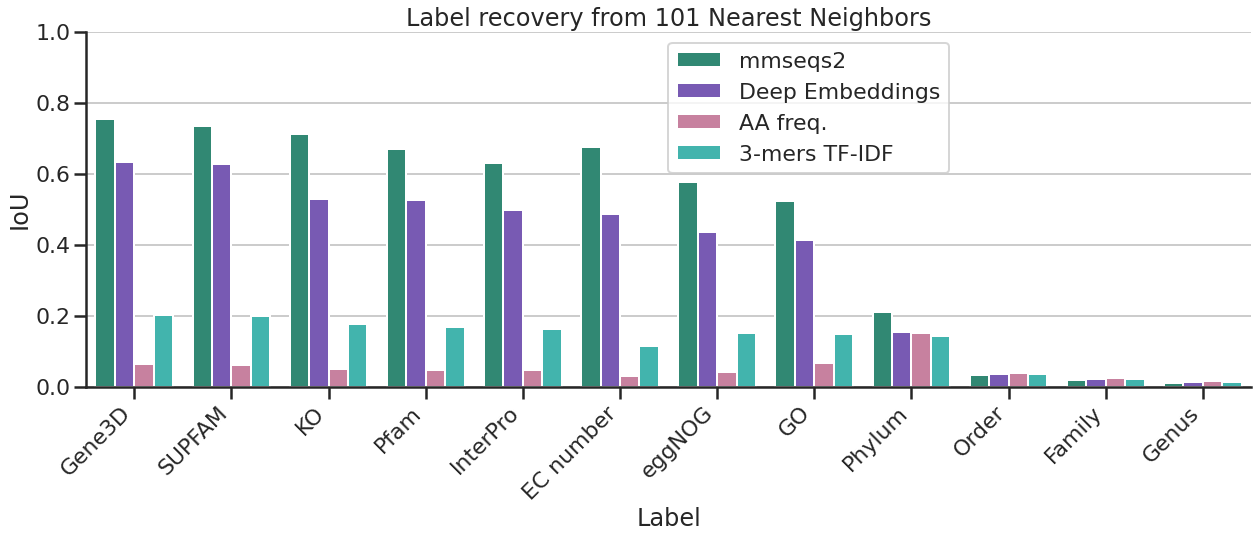

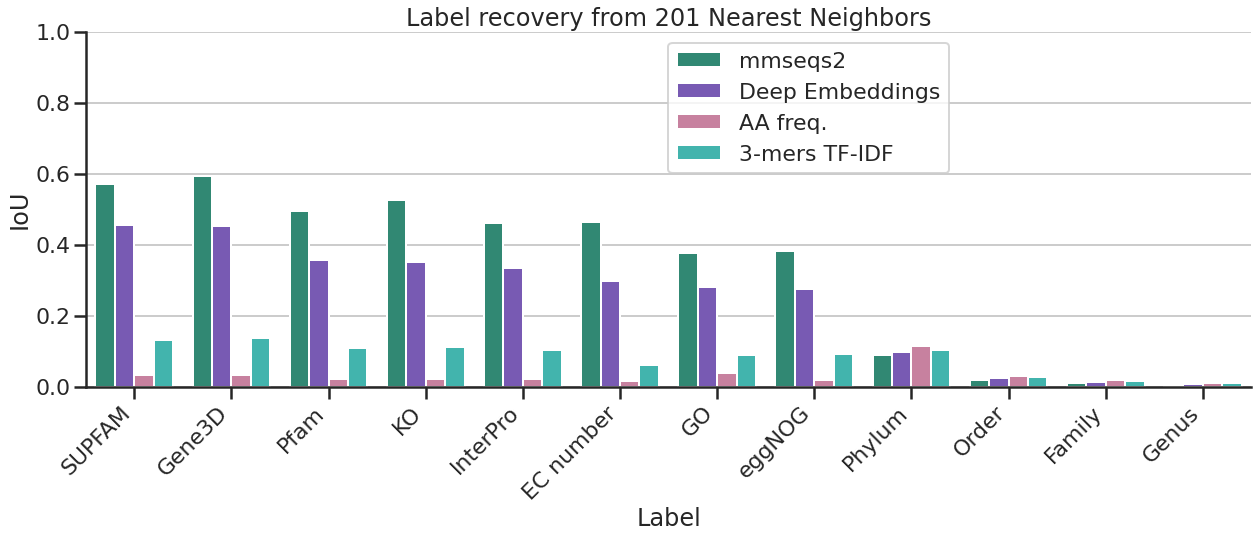

In [37]:
sns.set(context='poster', style='white')

for classificator in results['k'].unique():
    
    data = (
        results
        .query('Metric == "IoU" & k==@classificator')
        .groupby(['Representation', 'Label'])['Value']
        .mean()
        .reset_index()
    )

    order = (
        data.query('Representation == "Deep Embeddings"')
            .groupby('Label')
            .mean()
            .sort_values('Value', ascending=False).index
    )

    plt.figure(figsize=(18, 8))
    sns.barplot(
        data=data,
        x='Label',
        y='Value',
        hue='Representation',
        order=order,
        ci=10,
        hue_order=results['Representation'].sort_values(ascending=False).unique(),
        palette=palette,
    )
    
    plt.ylim(0,1)
    plt.ylabel('IoU')
    plt.xticks(rotation=45, ha='right')
    plt.gca().yaxis.tick_left()
    plt.gca().xaxis.tick_bottom()
    
    sns.despine()
    plt.title(f'Label recovery from {classificator} Nearest Neighbors')
    plt.legend(bbox_to_anchor=(0.75, 1.0))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [38]:
results.query('Metric == "IoU"').groupby(['Label', 'Representation', 'k'])['Value'].mean().unstack(2).round(3).loc[(order, slice(None))].to_excel('results.xls')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


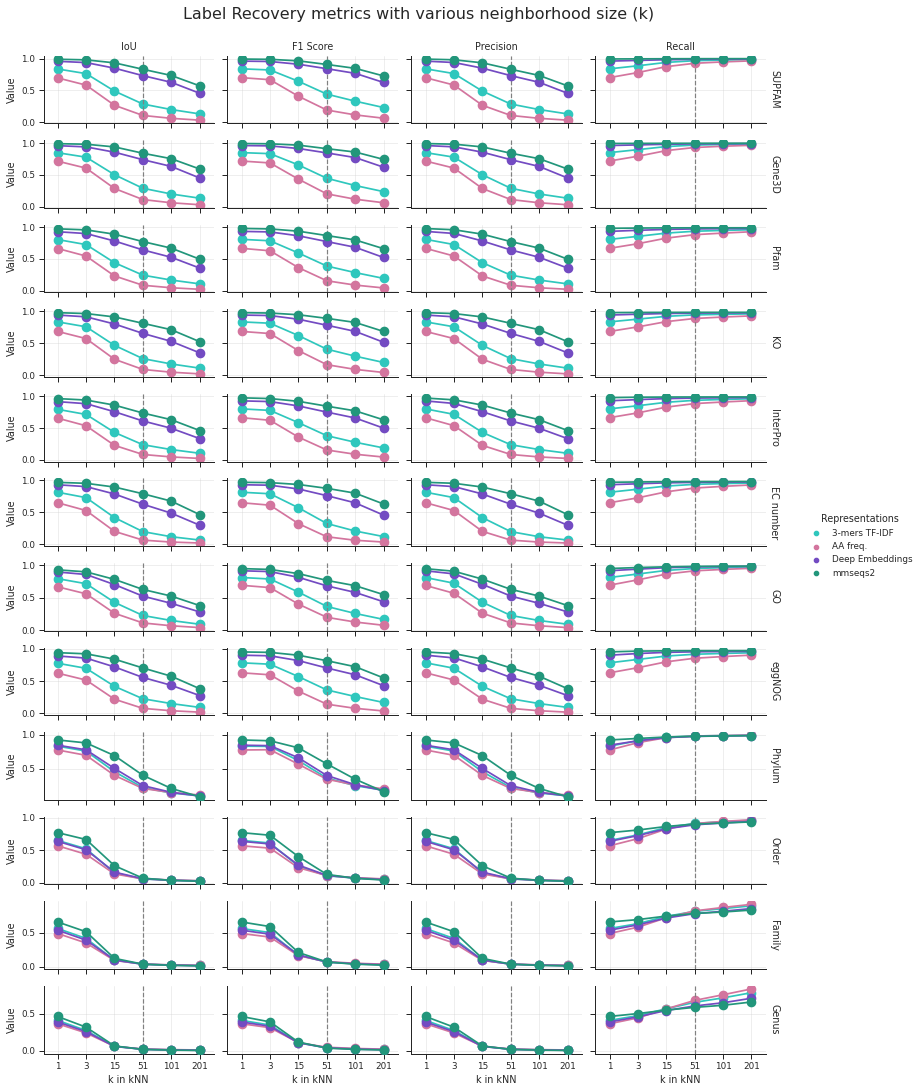

In [16]:
sns.set(context='paper', style="ticks")

# order = (
#     results
#     .groupby('Label')['Value']
#     .mean()
#     .sort_values(ascending=False)
#     .index
# )

# Keep order from the previous plot
# (order = order)

g = sns.FacetGrid(
    # From unknown reason it is needed to 
    # have sorted data to have correct colors on all plots
    results.sort_values('Representation', ascending=False), 
    col="Metric",
    row="Label",
    height=1.4,
    aspect=2.2,
    margin_titles=True,
    sharey="row",
    row_order=order,
    col_order=['IoU', 'F1 Score', 'Precision', 'Recall'],
    gridspec_kws=dict(hspace=0.25, wspace=0.08)
)
g.map_dataframe(
    sns.pointplot,
    x="k",
    y="Value",
    hue="Representation",
    palette=palette,
    scale=0.8,
    errwidth=1.0
)
g.refline(x=3)
g.set_axis_labels("k in kNN", "Value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Representations', adjust_subtitles=True)


g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Label Recovery metrics with various neighborhood size (k)', fontsize=16, y=0.99)

for _, ax in g.axes_dict.items():
    ax.grid(alpha=0.4)
    
    plt.setp(ax.collections, sizes=[70])